In [2]:
import os
import json
import numpy as np

from bayes_opt import BayesianOptimization
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from bayes_opt import UtilityFunction

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [3]:
import gradient_clipping

2023-12-13 18:47:55,304 WARNING From c:\Users\janma\.virtualenvs\LSTM-crystal-growth-CmWzVl6A\lib\site-packages\keras\src\utils\tf_utils.py:585: The name tf.executing_eagerly_outside_functions is deprecated. Please use tf.compat.v1.executing_eagerly_outside_functions instead.



In [4]:
pbounds = {"clipnorm": (0.0, 100.0)}
optimizer = BayesianOptimization(
    f=gradient_clipping.negative_optimization_function,
    pbounds=pbounds,
    verbose=2,
    allow_duplicate_points=True,
    random_state=1,
)

cur_path = os.path.abspath("")
print(cur_path)
logs_path = os.path.join(cur_path, "logs", "gradient_clipping.json")

logger = JSONLogger(path=logs_path, reset=False)
if os.path.exists(logs_path):
    load_logs(optimizer, logs=[logs_path])

c:\Users\janma\Programovani\diplomova_prace\LSTM-crystal-growth\experiments\gradient_clipping


In [5]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["clipnorm"]] for res in optimizer.res])
    y_obs = np.array([-res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((x.min(), x.max()))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('clipnorm', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((x.min(), x.max()))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('clipnorm', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

c:\Users\janma\.virtualenvs\LSTM-crystal-growth-CmWzVl6A\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


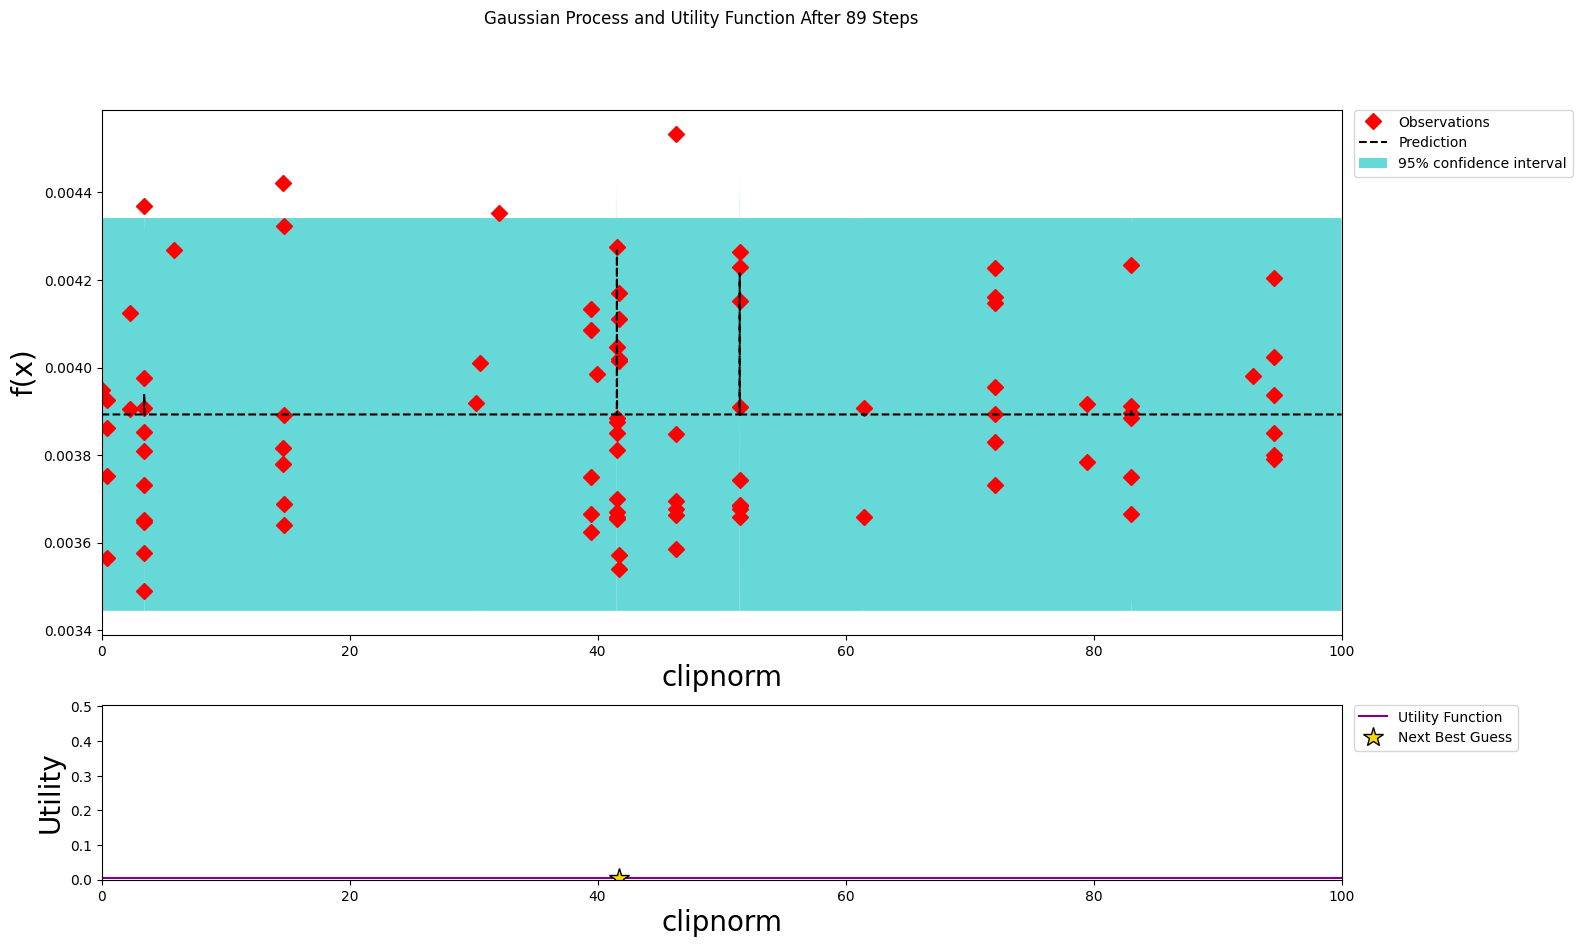

In [6]:
x = np.linspace(0, 100, 10000).reshape(-1,1)

plot_gp(optimizer, x)

In [7]:
optimizer.max

{'target': -0.003489546990022063, 'params': {'clipnorm': 3.4382207010260624}}

In [8]:
if os.path.exists(logs_path):
    print("Loading logs...")

data_list = []
with open(logs_path, "r") as file:
    for line in file:
        data_dict = json.loads(line)
        target = data_dict["target"]
        clipnorm = data_dict["params"]["clipnorm"]
        data_list.append([target, clipnorm])
data_list = np.array(data_list)
data_list[:,0] = -data_list[:,0]
sort_idx = data_list.argsort(axis=0)
data_list = data_list[sort_idx[:, 0], :]

print(data_list[::-1,:])


Loading logs...
[[4.53449213e-03 4.63600753e+01]
 [4.42113373e-03 1.46736876e+01]
 [4.36959004e-03 3.43688043e+00]
 [4.35339019e-03 3.20621267e+01]
 [4.32225489e-03 1.46759667e+01]
 [4.27587470e-03 4.15641293e+01]
 [4.26820978e-03 5.80527314e+00]
 [4.26466903e-03 5.14651895e+01]
 [4.23459772e-03 8.30373604e+01]
 [4.23002730e-03 5.14615466e+01]
 [4.22651791e-03 7.20354095e+01]
 [4.20363725e-03 9.45480524e+01]
 [4.17113970e-03 4.17036595e+01]
 [4.16154596e-03 7.20327633e+01]
 [4.15109142e-03 5.14637339e+01]
 [4.14774886e-03 7.20344496e+01]
 [4.13442124e-03 3.94969650e+01]
 [4.12476880e-03 2.31248008e+00]
 [4.11140104e-03 4.17020558e+01]
 [4.08658795e-03 3.94951781e+01]
 [4.04592992e-03 4.15613045e+01]
 [4.02448408e-03 9.45452876e+01]
 [4.01983678e-03 4.17026277e+01]
 [4.01577149e-03 4.17016371e+01]
 [4.01055799e-03 3.05337197e+01]
 [3.98611957e-03 3.99733136e+01]
 [3.97970486e-03 9.28337669e+01]
 [3.97582885e-03 3.44025052e+00]
 [3.95463200e-03 7.20321890e+01]
 [3.94849195e-03 1.14374817

In [23]:
conf_dict

'{"target": -0.0035387830110266806, "params": {"clipnorm": 41.7022004702574}, "datetime": {"datetime": "2023-12-11 00:53:36", "elapsed": 0.0, "delta": 0.0}}\n{"target": -0.0037307685241103174, "params": {"clipnorm": 72.0324493442158}, "datetime": {"datetime": "2023-12-11 01:00:47", "elapsed": 430.385901, "delta": 430.385901}}\n{"target": -0.003948491951450706, "params": {"clipnorm": 0.011437481734488664}, "datetime": {"datetime": "2023-12-11 01:08:15", "elapsed": 878.731282, "delta": 448.345381}}\n{"target": -0.003919315477833152, "params": {"clipnorm": 30.233257263183976}, "datetime": {"datetime": "2023-12-11 01:15:20", "elapsed": 1303.239725, "delta": 424.508443}}\n{"target": -0.0038926223758608105, "params": {"clipnorm": 14.675589081711305}, "datetime": {"datetime": "2023-12-11 01:21:59", "elapsed": 1702.543951, "delta": 399.304226}}\n{"target": -0.0038744478719308973, "params": {"clipnorm": 41.562715463584254}, "datetime": {"datetime": "2023-12-11 01:30:14", "elapsed": 2197.972485,